# PV Production

Use the Solcast dataset to calculate the PV production for a given location. This notebook will study the data from Bath, UK.

The data was obtained from the [Solcast](https://www.solcast.com/) website.

In [32]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

# remove warnings
import warnings
warnings.filterwarnings('ignore')

# remove pandas warning
pd.options.mode.chained_assignment = None  # default='warn'

# matplotlib style size
plt.rcParams['figure.figsize'] = (12.8, 7.2)


In [2]:
df = pd.read_csv('../data/Solcast_PT30M.csv')
df.head()


,PeriodEnd,PeriodStart,Period,AirTemp,CloudOpacity,Dni,PrecipitableWater,RelativeHumidity,WindDirection10m,WindSpeed10m
0,2007-01-01T01:00:00Z,2007-01-01T00:30:00Z,PT30M,8.0,0.0,0,11.6,81.4,249,9.9
1,2007-01-01T01:30:00Z,2007-01-01T01:00:00Z,PT30M,7.7,0.0,0,11.3,83.3,251,9.7
2,2007-01-01T02:00:00Z,2007-01-01T01:30:00Z,PT30M,7.3,0.0,0,11.1,85.2,253,9.5
3,2007-01-01T02:30:00Z,2007-01-01T02:00:00Z,PT30M,7.0,0.0,0,10.9,87.2,255,9.4
4,2007-01-01T03:00:00Z,2007-01-01T02:30:00Z,PT30M,6.6,0.0,0,10.7,89.2,256,9.2


In [3]:
df['PeriodEnd'] = pd.to_datetime(df['PeriodEnd'])
df['PeriodStart'] = pd.to_datetime(df['PeriodStart'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265870 entries, 0 to 265869
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   PeriodEnd          265870 non-null  datetime64[ns, UTC]
 1   PeriodStart        265870 non-null  datetime64[ns, UTC]
 2   Period             265870 non-null  object             
 3   AirTemp            265870 non-null  float64            
 4   CloudOpacity       265870 non-null  float64            
 5   Dni                265870 non-null  int64              
 6   PrecipitableWater  265870 non-null  float64            
 7   RelativeHumidity   265870 non-null  float64            
 8   WindDirection10m   265870 non-null  int64              
 9   WindSpeed10m       265870 non-null  float64            
dtypes: datetime64[ns, UTC](2), float64(5), int64(2), object(1)
memory usage: 20.3+ MB


In [4]:
df.isnull().sum()

PeriodEnd            0
PeriodStart          0
Period               0
AirTemp              0
CloudOpacity         0
Dni                  0
PrecipitableWater    0
RelativeHumidity     0
WindDirection10m     0
WindSpeed10m         0
dtype: int64

In [5]:
df.max()

PeriodEnd            2022-03-01 23:30:00+00:00
PeriodStart          2022-03-01 23:00:00+00:00
Period                                   PT30M
AirTemp                                   31.4
CloudOpacity                             100.0
Dni                                        957
PrecipitableWater                         47.6
RelativeHumidity                         100.0
WindDirection10m                           360
WindSpeed10m                              16.8
dtype: object

In [6]:
df.min()

PeriodEnd            2007-01-01 01:00:00+00:00
PeriodStart          2007-01-01 00:30:00+00:00
Period                                   PT30M
AirTemp                                   -9.0
CloudOpacity                               0.0
Dni                                          0
PrecipitableWater                          2.6
RelativeHumidity                          30.6
WindDirection10m                             0
WindSpeed10m                               0.0
dtype: object

In [7]:
# numpy range of days between start and end
days = np.arange(df['PeriodStart'].min(), df['PeriodStart'].max(), dtype='datetime64[D]')


In [8]:
days.size, df['PeriodStart'].dt.date.nunique()

(5538, 5539)

From what we see so far:
  - The data has no null values
  - The values make sense
  - There are no missing days

Are there missing 30-minute interval values, though?

In [9]:
# numpy range of days, with 30 minutes granularity, between start and end
days_30min = np.arange(df['PeriodStart'].min(), df['PeriodStart'].max(), dtype='datetime64[30m]')


In [10]:
days_30min.size, df['PeriodStart'].nunique()

(265869, 265870)

No missing values at all! The data is perfect as is.

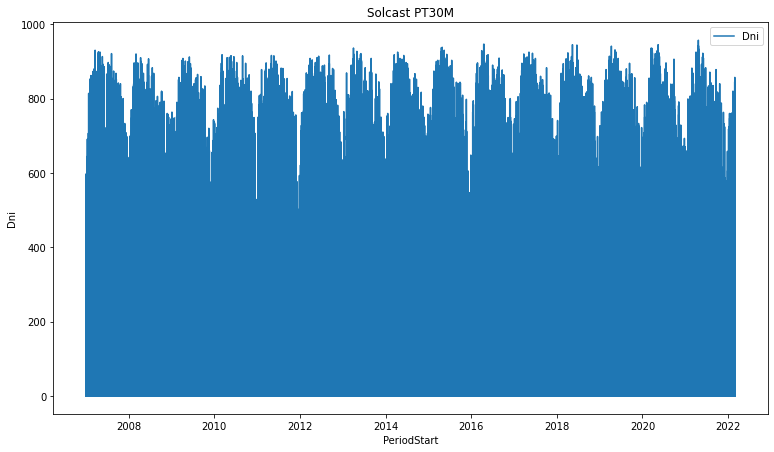

In [11]:
# plot the data
plt.title('Solcast PT30M')

plt.plot(df['PeriodStart'], df['Dni'], label='Dni')
plt.xlabel('PeriodStart')
plt.ylabel('Dni')
plt.legend()
plt.show()


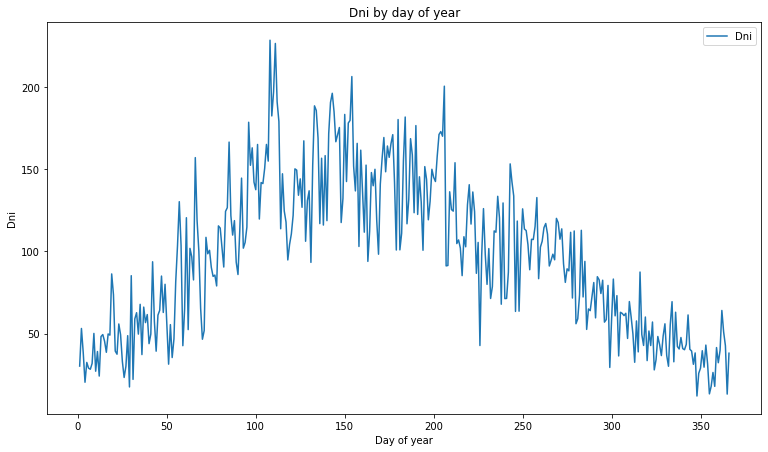

In [12]:
# group in year
df_year = df.groupby(df['PeriodStart'].dt.dayofyear).mean().reset_index()

df_year.plot(x='PeriodStart', y='Dni', label='Dni', title='Dni by day of year')
plt.xlabel('Day of year')
plt.ylabel('Dni')
plt.legend()
plt.show()


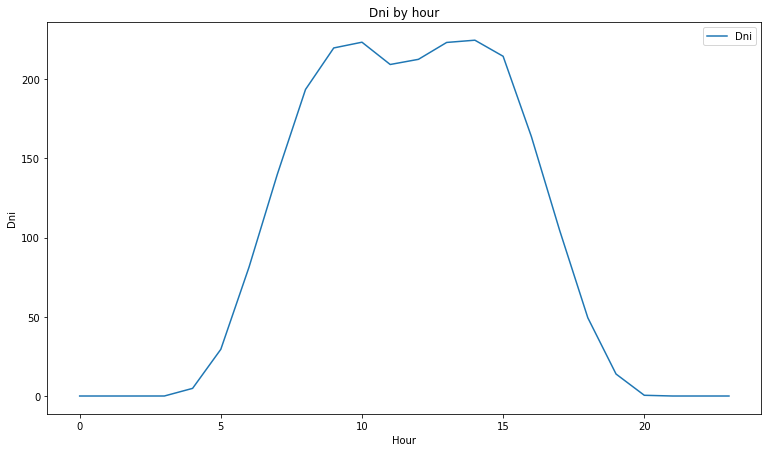

In [13]:
df_daily = df.groupby(df['PeriodStart'].dt.hour).mean().reset_index()

df_daily.plot(x='PeriodStart', y='Dni', label='Dni', title="Dni by hour")
plt.xlabel('Hour')
plt.ylabel('Dni')
plt.legend()
plt.show()


## Simulation

In [23]:
df_banes = pd.read_csv("../data/BANES_weather_merged.csv", parse_dates=['time'])
df_banes = df_banes.groupby(['time', 'location']).mean().reset_index()
df_banes.head()


,time,location,energy,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco
0,2006-10-01 00:30:00,Guildhall Electricity Supply 1 (HH),32.8,14.95,13.80,93.0,0.0,0.0,175.0,13.9,NaN,1001.8,NaN
1,2006-10-01 01:00:00,Guildhall Electricity Supply 1 (HH),33.0,14.80,13.50,92.0,0.0,0.0,180.0,14.8,NaN,1001.7,NaN
2,2006-10-01 01:30:00,Bath Central Library Electricity (HH),5.9,14.75,13.35,91.5,0.0,0.0,180.0,13.9,NaN,1001.7,NaN
3,2006-10-01 01:30:00,Guildhall Electricity Supply 1 (HH),32.7,14.75,13.35,91.5,0.0,0.0,180.0,13.9,NaN,1001.7,NaN
4,2006-10-01 02:00:00,Guildhall Electricity Supply 1 (HH),32.2,14.70,13.20,91.0,0.0,0.0,180.0,13.0,NaN,1001.7,NaN


In [24]:
# parse date to datetime[ns, UTC]
df_banes['time'] = pd.to_datetime(df_banes['time'], utc=True)

In [25]:
df_banes = df_banes[['time', 'location', 'energy']]
df_banes.rename(columns={'time': 'PeriodStart'}, inplace=True)


In [26]:
df_merged = df_banes.merge(df, on='PeriodStart', how='left')
df_merged.head()

,PeriodStart,location,energy,PeriodEnd,Period,AirTemp,CloudOpacity,Dni,PrecipitableWater,RelativeHumidity,WindDirection10m,WindSpeed10m
0,2006-10-01 00:30:00+00:00,Guildhall Electricity Supply 1 (HH),32.8,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006-10-01 01:00:00+00:00,Guildhall Electricity Supply 1 (HH),33.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2006-10-01 01:30:00+00:00,Bath Central Library Electricity (HH),5.9,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2006-10-01 01:30:00+00:00,Guildhall Electricity Supply 1 (HH),32.7,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2006-10-01 02:00:00+00:00,Guildhall Electricity Supply 1 (HH),32.2,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
df_merged.dropna(inplace=True)
df_merged.head()

,PeriodStart,location,energy,PeriodEnd,Period,AirTemp,CloudOpacity,Dni,PrecipitableWater,RelativeHumidity,WindDirection10m,WindSpeed10m
6612,2007-01-01 00:30:00+00:00,Bath Central Library Electricity (HH),18.0,2007-01-01 01:00:00+00:00,PT30M,8.0,0.0,0.0,11.6,81.4,249.0,9.9
6613,2007-01-01 00:30:00+00:00,Guildhall Electricity Supply 1 (HH),33.0,2007-01-01 01:00:00+00:00,PT30M,8.0,0.0,0.0,11.6,81.4,249.0,9.9
6614,2007-01-01 01:00:00+00:00,Bath Central Library Electricity (HH),18.1,2007-01-01 01:30:00+00:00,PT30M,7.7,0.0,0.0,11.3,83.3,251.0,9.7
6615,2007-01-01 01:00:00+00:00,Guildhall Electricity Supply 1 (HH),33.4,2007-01-01 01:30:00+00:00,PT30M,7.7,0.0,0.0,11.3,83.3,251.0,9.7
6616,2007-01-01 01:30:00+00:00,Bath Central Library Electricity (HH),18.2,2007-01-01 02:00:00+00:00,PT30M,7.3,0.0,0.0,11.1,85.2,253.0,9.5


The formula to estimate the production of an household is the following:

$E(t) = A * r(t) * g(t) * p$

Where $E(t)$ is the energy produced at time $t$, $A$ is the area of the PV panels, $r(t)$ is the performance of a PV cell at a time $t$, $g(t)$ is the irradiance at time $t$, and $p$ is the overall performance of the panel.

The most common $r$ values are between 15 and 22, and for $p$ we will consider 1.

In [46]:
# foreach location provide a random number of panel area following a normal distribution
locations = list(map(lambda x: (x, np.abs(np.floor(np.random.normal(loc=7, scale=4)))), df_merged['location'].unique()))
locations


[('Bath Central Library Electricity (HH)', 3.0),
 ('Guildhall Electricity Supply 1 (HH)', 7.0),
 ('Moorland Rd Library', 1.0),
 ('##Nothgate House Electricity Supply 3', 1.0),
 ('##Weston Library Electricity Supply 1', 4.0),
 ('Midsomer Norton Library (P272 HH)', 5.0),
 ('Swallow Street Stores & Workshop Electri', 15.0),
 ('Royal Victoria Park Nursery Electricity', 7.0),
 ('Stanton Drew Primary School (P272 HH)', 9.0),
 ('The Hollies Offices MSN (P272 HH)', 8.0),
 ('##Castle Primary School Electricity Supply', 16.0),
 ('## OLD Paulton Library Electricity Supply 1', 10.0),
 ('##Radstock Library (Town Council)', 6.0),
 ('##Saltford Library (Community Library)', 6.0),
 ('##Northgate House Electricity Supply 2', 1.0),
 ('##Northgate House Electricity Supply 1', 6.0),
 ('##Lewis House Electricity Supply 1', 4.0),
 ('St Marks C of E School (HH)', 11.0),
 ('Keynsham Childrens Centre - Castle School Annexe', 12.0),
 ('Junior School Electricity - Corridor 2 heating', 2.0),
 ('Junior School Elec

In [47]:
for i in tqdm(range(len(locations))):
    location, A = locations[i]
    df_merged.loc[df_merged['location'] == location, 'A'] = A
    
df_merged.head()


100%|██████████| 72/72 [01:05<00:00,  1.11it/s]


,PeriodStart,location,energy,PeriodEnd,Period,AirTemp,CloudOpacity,Dni,PrecipitableWater,RelativeHumidity,WindDirection10m,WindSpeed10m,A
6612,2007-01-01 00:30:00+00:00,Bath Central Library Electricity (HH),18.0,2007-01-01 01:00:00+00:00,PT30M,8.0,0.0,0.0,11.6,81.4,249.0,9.9,3.0
6613,2007-01-01 00:30:00+00:00,Guildhall Electricity Supply 1 (HH),33.0,2007-01-01 01:00:00+00:00,PT30M,8.0,0.0,0.0,11.6,81.4,249.0,9.9,7.0
6614,2007-01-01 01:00:00+00:00,Bath Central Library Electricity (HH),18.1,2007-01-01 01:30:00+00:00,PT30M,7.7,0.0,0.0,11.3,83.3,251.0,9.7,3.0
6615,2007-01-01 01:00:00+00:00,Guildhall Electricity Supply 1 (HH),33.4,2007-01-01 01:30:00+00:00,PT30M,7.7,0.0,0.0,11.3,83.3,251.0,9.7,7.0
6616,2007-01-01 01:30:00+00:00,Bath Central Library Electricity (HH),18.2,2007-01-01 02:00:00+00:00,PT30M,7.3,0.0,0.0,11.1,85.2,253.0,9.5,3.0


In [50]:
df_merged['r'] = np.random.random(df_merged.shape[0]) * 7 + 15
df_merged.head()

,PeriodStart,location,energy,PeriodEnd,Period,AirTemp,CloudOpacity,Dni,PrecipitableWater,RelativeHumidity,WindDirection10m,WindSpeed10m,A,r
6612,2007-01-01 00:30:00+00:00,Bath Central Library Electricity (HH),18.0,2007-01-01 01:00:00+00:00,PT30M,8.0,0.0,0.0,11.6,81.4,249.0,9.9,3.0,17.491769
6613,2007-01-01 00:30:00+00:00,Guildhall Electricity Supply 1 (HH),33.0,2007-01-01 01:00:00+00:00,PT30M,8.0,0.0,0.0,11.6,81.4,249.0,9.9,7.0,15.204983
6614,2007-01-01 01:00:00+00:00,Bath Central Library Electricity (HH),18.1,2007-01-01 01:30:00+00:00,PT30M,7.7,0.0,0.0,11.3,83.3,251.0,9.7,3.0,21.200910
6615,2007-01-01 01:00:00+00:00,Guildhall Electricity Supply 1 (HH),33.4,2007-01-01 01:30:00+00:00,PT30M,7.7,0.0,0.0,11.3,83.3,251.0,9.7,7.0,19.836375
6616,2007-01-01 01:30:00+00:00,Bath Central Library Electricity (HH),18.2,2007-01-01 02:00:00+00:00,PT30M,7.3,0.0,0.0,11.1,85.2,253.0,9.5,3.0,15.229212


In [54]:
df_merged['E'] = df_merged['Dni'] * df_merged['A'] * df_merged['r'] / 1000
df_merged = df_merged[['PeriodStart', 'location', 'energy', 'E', 'A', 'r', 'Dni']]
df_merged.head()

,PeriodStart,location,energy,E,A,r,Dni
6612,2007-01-01 00:30:00+00:00,Bath Central Library Electricity (HH),18.0,0.0,3.0,17.491769,0.0
6613,2007-01-01 00:30:00+00:00,Guildhall Electricity Supply 1 (HH),33.0,0.0,7.0,15.204983,0.0
6614,2007-01-01 01:00:00+00:00,Bath Central Library Electricity (HH),18.1,0.0,3.0,21.200910,0.0
6615,2007-01-01 01:00:00+00:00,Guildhall Electricity Supply 1 (HH),33.4,0.0,7.0,19.836375,0.0
6616,2007-01-01 01:30:00+00:00,Bath Central Library Electricity (HH),18.2,0.0,3.0,15.229212,0.0


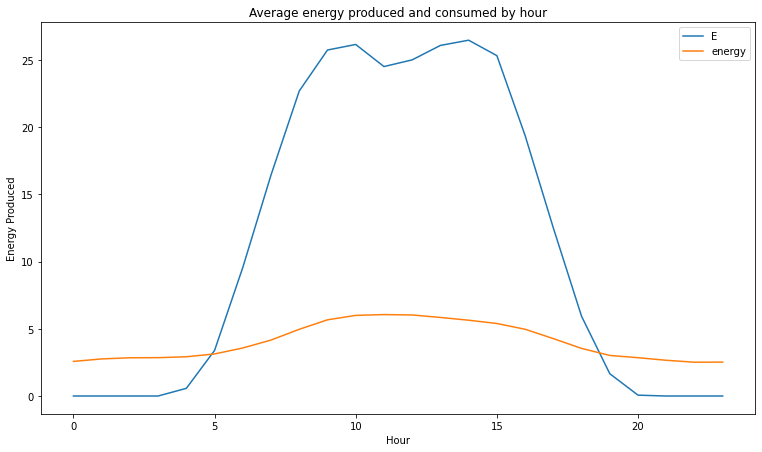

In [66]:
# df_merged.groupby(df_merged['PeriodStart'].dt.hour).mean().plot(y='E', title='Energy produced by hour')
# df_merged.groupby(df_merged['PeriodStart'].dt.hour).mean().plot(y='energy', title='Energy consumed by hour')
grouped = df_merged.groupby(df_merged['PeriodStart'].dt.hour).mean().reset_index()
plt.title('Average energy produced and consumed by hour')
plt.plot(grouped['PeriodStart'], grouped['E'], label='E')
plt.plot(grouped['PeriodStart'], grouped['energy'], label='energy')
plt.xlabel('Hour')
plt.ylabel('Energy Produced')
plt.legend()
plt.show()

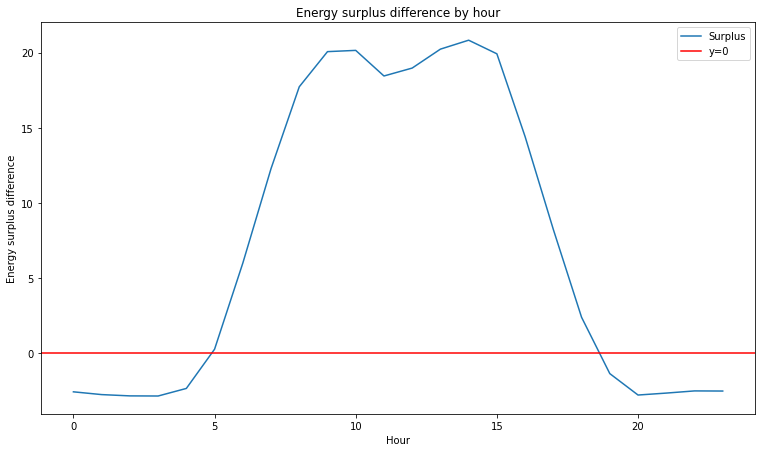

In [58]:
df_diff = df_merged.groupby(df_merged['PeriodStart'].dt.hour).mean().reset_index()
df_diff['diff'] = df_diff['E'] - df_diff['energy']

df_diff.plot(x='PeriodStart', y='diff', title='Energy surplus difference by hour')
plt.xlabel('Hour')
plt.ylabel('Energy surplus difference')
# plot a line at y = 0
plt.axhline(y=0, color='r', linestyle='-')
plt.legend(['Surplus', 'y=0'])
plt.show()

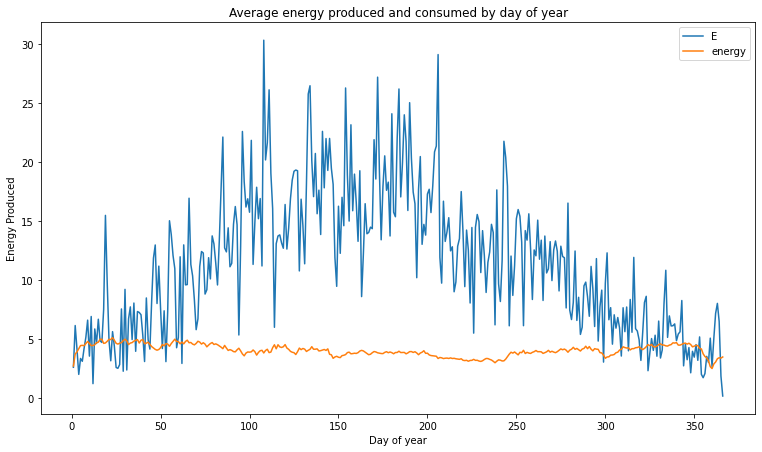

In [67]:
grouped = df_merged.groupby(df_merged['PeriodStart'].dt.dayofyear).mean().reset_index()
plt.title('Average energy produced and consumed by day of year')
plt.plot(grouped['PeriodStart'], grouped['E'], label='E')
plt.plot(grouped['PeriodStart'], grouped['energy'], label='energy')
plt.xlabel('Day of year')
plt.ylabel('Energy Produced')
plt.legend()
plt.show()

In [69]:
# pick a location
location = df_merged.location.unique()[0]
location

'Bath Central Library Electricity (HH)'

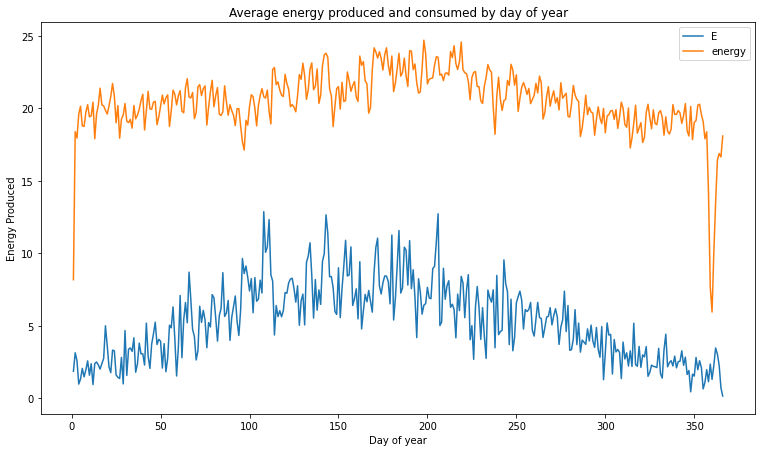

In [70]:
df_library = df_merged[df_merged['location'] == location]

grouped = df_library.groupby(df_library['PeriodStart'].dt.dayofyear).mean().reset_index()
plt.title('Average energy produced and consumed by day of year')
plt.plot(grouped['PeriodStart'], grouped['E'], label='E')
plt.plot(grouped['PeriodStart'], grouped['energy'], label='energy')
plt.xlabel('Day of year')
plt.ylabel('Energy Produced')
plt.legend()
plt.show()


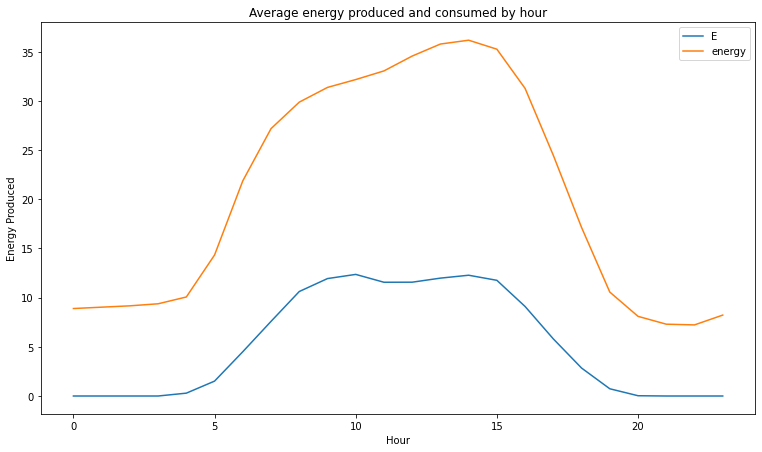

In [71]:
grouped = df_library.groupby(df_library['PeriodStart'].dt.hour).mean().reset_index()
plt.title('Average energy produced and consumed by hour')
plt.plot(grouped['PeriodStart'], grouped['E'], label='E')
plt.plot(grouped['PeriodStart'], grouped['energy'], label='energy')
plt.xlabel('Hour')
plt.ylabel('Energy Produced')
plt.legend()
plt.show()


In [73]:
df_library.describe()

,energy,E,A,r,Dni
count,149481.000000,149481.000000,149481.0,149481.000000,149481.000000
mean,20.511227,5.267493,3.0,18.504184,94.817990
std,14.884853,11.981682,0.0,2.022163,214.112094
min,0.000000,0.000000,3.0,15.000069,0.000000
25%,4.600000,0.000000,3.0,16.757101,0.000000
50%,19.700000,0.000000,3.0,18.506009,0.000000
75%,32.900000,0.936294,3.0,20.252906,17.000000
max,59.400000,61.355632,3.0,21.999996,946.000000
